# DACON : 신용카드 사용자 연체 예측 AI 경진대회

## 1. Load libs & data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')
submission = pd.read_csv('./open/sample_submission.csv')

In [4]:
print(train.shape, test.shape, submission.shape)

(26457, 20) (10000, 19) (10000, 4)


## 2. Data Preprocessing

In [5]:
# 변수 제거
train.drop(['occyp_type', 'child_num', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['occyp_type', 'child_num', 'FLAG_MOBIL'], axis=1, inplace=True)

In [6]:
# 음수 => 양수 
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x: -x)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x: -x)

train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: -x)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: -x)

train['begin_month'] = train['begin_month'].apply(lambda x: -x)
test['begin_month'] = test['begin_month'].apply(lambda x: -x)

In [7]:
# DAYS_BIRTH로 나이 변수 만들어주기
train['Age'] = train['DAYS_BIRTH'].apply(lambda x: int(x/365))
test['Age'] = test['DAYS_BIRTH'].apply(lambda x: int(x/365))

In [8]:
# 원-핫 인코딩
train['gender'] = train['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0
test['gender'] = test['gender'].apply(lambda x: 1 if x=='M' else 0) # Male=1, Female=0

train['car'] = train['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
test['car'] = test['car'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

train['reality'] = train['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0
test['reality'] = test['reality'].apply(lambda x: 1 if x=='Y' else 0) # Yes=1, No=0

In [9]:
# 라벨 인코딩
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

train['income_type'] = enc.fit_transform(train['income_type'])
test['income_type'] = enc.transform(test['income_type'])

train['edu_type'] = enc.fit_transform(train['edu_type'])
test['edu_type'] = enc.transform(test['edu_type'])

train['family_type'] = enc.fit_transform(train['family_type'])
test['family_type'] = enc.transform(test['family_type'])

train['house_type'] = enc.fit_transform(train['house_type'])
test['house_type'] = enc.fit_transform(test['house_type'])

In [10]:
# target
train['credit'] = train['credit'].astype('int')

In [11]:
train

,index,gender,car,reality,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,Age
0,0,0,0,0,202500.0,0,1,1,2,13899,4709,0,0,0,2.0,6.0,1,38
1,1,0,0,1,247500.0,0,4,0,1,11380,1540,0,0,1,3.0,5.0,1,31
2,2,1,1,1,450000.0,4,1,1,1,19087,4434,0,1,0,2.0,22.0,2,52
3,3,0,0,1,202500.0,0,4,1,1,15088,2092,0,1,0,2.0,37.0,0,41
4,4,0,1,1,157500.0,2,1,1,1,15037,2105,0,0,0,2.0,26.0,2,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,0,0,0,225000.0,2,4,1,1,12079,1984,0,0,0,4.0,2.0,1,33
26453,26453,0,0,1,180000.0,4,1,2,1,15291,2475,0,0,0,2.0,47.0,2,41
26454,26454,0,1,0,292500.0,4,4,0,5,10082,2015,0,0,0,2.0,25.0,2,27
26455,26455,1,0,1,171000.0,4,2,3,1,10145,107,0,0,0,1.0,59.0,2,27


## Modeling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

In [13]:
train_x = train.drop(['index', 'credit'], axis=1)
train_y = train[['credit']]
test_x = test

In [14]:
print(train_x.shape, train_y.shape, test.shape)

(26457, 16) (26457, 1) (10000, 17)


In [15]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y,
                                                  stratify=train_y, test_size=0.3, random_state = 99)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(18519, 16) (7938, 16) (18519, 1) (7938, 1)


In [16]:
# randomforest
rf_base = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=0)
rf_base.fit(X_train, y_train)
y_pred = rf_base.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       967
           1       0.77      0.21      0.33      1880
           2       0.69      1.00      0.81      5091

    accuracy                           0.69      7938
   macro avg       0.49      0.40      0.38      7938
weighted avg       0.62      0.69      0.60      7938



In [17]:
def scaler(train, test, scaling):

    from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler
    
    if scaling=='MinMaxScaler':
        sc = MinMaxScaler()
    if scaling=='MaxAbsScaler':
        sc = MaxAbsScaler()
    if scaling=='StandardScaler':
        sc = StandardScaler()
    if scaling=='RobustScaler':
        sc = RobustScaler()

    train_scaled = sc.fit_transform(train)
    test_scaled = sc.transform(test)
    
    return train_scaled, test_scaled

In [18]:
for scaling_type in ['MinMaxScaler', 'MaxAbsScaler', 'StandardScaler', 'RobustScaler']:
    
    # scaling
    X_train_scaled, X_val_scaled = scaler(X_train, X_val, scaling=scaling_type)
    
    # random forest
    rf_base = RandomForestClassifier(random_state=99)
    rf_base.fit(X_train_scaled, y_train)
    y_pred = rf_base.predict(X_val_scaled)
    
    print('============ {} ============'.format(scaling_type))
    print(classification_report(y_val, y_pred))

============ MinMaxScaler ============
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       967
           1       0.59      0.47      0.52      1880
           2       0.75      0.87      0.81      5091

    accuracy                           0.70      7938
   macro avg       0.60      0.53      0.55      7938
weighted avg       0.68      0.70      0.68      7938

============ MaxAbsScaler ============
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       967
           1       0.59      0.47      0.52      1880
           2       0.75      0.87      0.81      5091

    accuracy                           0.70      7938
   macro avg       0.60      0.53      0.55      7938
weighted avg       0.68      0.70      0.68      7938

============ StandardScaler ============
              precision    recall  f1-score   support

           0       0.45      0.26      0.33       967
          

In [19]:
# hyperparameter tuning

X_train_scaled, X_val_scaled = scaler(X_train, X_val, scaling='StandardScaler')

params ={
    'n_estimators':[20, 40, 60, 80, 100],
    'max_depth':[4, 6, 10, 20],
    'min_samples_leaf':[4, 6, 12, 20, 30],
    'min_samples_split':[4, 6, 12, 20, 30]
}

rf = RandomForestClassifier(random_state=99)
grid_cv = GridSearchCV(rf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train_scaled, y_train)
grid_cv.best_estimator_

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=4,
                       random_state=99)

In [20]:
rf_tuned = grid_cv.best_estimator_
rf_tuned.fit(X_train_scaled, y_train)
y_pred = rf_tuned.predict(X_val_scaled)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.05      0.09       967
           1       0.72      0.30      0.42      1880
           2       0.70      0.98      0.82      5091

    accuracy                           0.71      7938
   macro avg       0.69      0.44      0.44      7938
weighted avg       0.70      0.71      0.64      7938



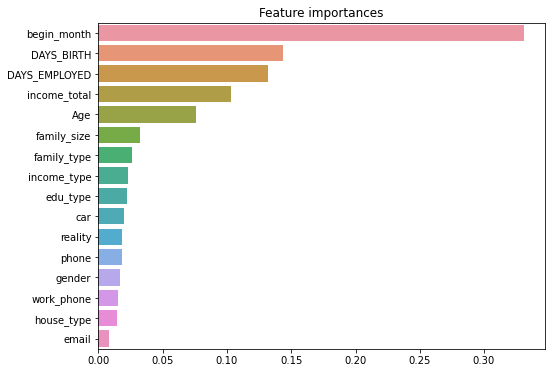

In [21]:
importances_values = rf_tuned.feature_importances_
importances = pd.Series(importances_values, index=X_train.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8, 6))
plt.title('Feature importances')
sns.barplot(x=importances, y=importances.index)
plt.show()

In [22]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss
from tensorflow.keras.utils import to_categorical

In [23]:
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
outcomes = []
for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
    X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
    y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
    rf_tuned.fit(X_train, y_train)
    predictions = rf_tuned.predict_proba(X_val)
    logloss = log_loss(to_categorical(y_val['credit']), predictions)
    outcomes.append(logloss)
    print(f"FOLD {n_fold} : logloss : {logloss}")
mean_outcome = np.mean(outcomes)

print("Mean : {}".format(mean_outcome))

FOLD 0 : logloss : 0.7251933945694962
FOLD 1 : logloss : 0.717560956385202
FOLD 2 : logloss : 0.709491074060748
FOLD 3 : logloss : 0.7306945957114968
FOLD 4 : logloss : 0.7195847058860275
FOLD 5 : logloss : 0.7357354436268357
FOLD 6 : logloss : 0.7251527129584667
FOLD 7 : logloss : 0.7241730507966679
FOLD 8 : logloss : 0.7184650264431964
FOLD 9 : logloss : 0.7202344056873474
Mean : 0.7226285366125484
